### Goal

#### Predict if the customer will subscribe (yes/no) to a term deposit

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from feature_engine.missing_data_imputers import CategoricalVariableImputer
from feature_engine.missing_data_imputers import RandomSampleImputer
from feature_engine.categorical_encoders import OneHotCategoricalEncoder
from feature_engine.variable_transformers import YeoJohnsonTransformer
from feature_engine.discretisers import EqualWidthDiscretiser
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn import metrics

### Exploratory Data Analysis

#### Exploring the data

In [3]:
data =  pd.read_csv("D:\Apziva\\term-deposit-marketing-2020.csv")

In [4]:
data.shape

(40000, 14)

In [5]:
data.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


In [322]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [323]:
# The target variable seems to be imbalanced
data["y"].value_counts()

no     37104
yes     2896
Name: y, dtype: int64

In [324]:
# Examining the data
for var in data.columns:
    print(var, data[var].unique())

age [58 44 33 47 35 28 42 43 41 29 53 57 51 45 60 56 32 25 40 39 52 46 36 49
 59 37 50 54 55 48 24 38 31 30 27 34 23 26 61 22 21 20 66 62 83 75 67 70
 65 68 64 69 72 71 19 76 85 63 90 82 73 74 78 80 94 79 77 86 95 81]
job ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
marital ['married' 'single' 'divorced']
education ['tertiary' 'secondary' 'unknown' 'primary']
default ['no' 'yes']
balance [  2143     29      2 ...   7222   3402 102127]
housing ['yes' 'no']
loan ['no' 'yes']
contact ['unknown' 'cellular' 'telephone']
day [ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24 25  1 10 22 31]
month ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr']
duration [ 261  151   76 ... 1880 1460 2219]
campaign [ 1  2  3  5  4  6  7  8  9 10 11 12 13 19 14 24 16 32 18 22 15 17 25 21
 43 51 63 41 26 28 55 50 38 23 20 29 31 37 30 46 27 58 33 35 34 36 39 44]


In [10]:
# making lists of variable types for numerical and categorical data
categorical = [var for var in data.columns if data[var].dtype == 'O' and var != 'y']

discrete = [var for var in data.columns if data[var].dtype != 'O' and len(data[var].unique()) < 20 
            and var != 'y']

continuous = [var for var in data.columns if data[var].dtype != 'O'and var not in discrete and var != 'y']

print(f'There are {len(continuous)} continuous variables')
print(f'There are {len(discrete)} discrete variables')
print(f'There are {len(categorical)} categorical variables')

There are 5 continuous variables
There are 0 discrete variables
There are 8 categorical variables


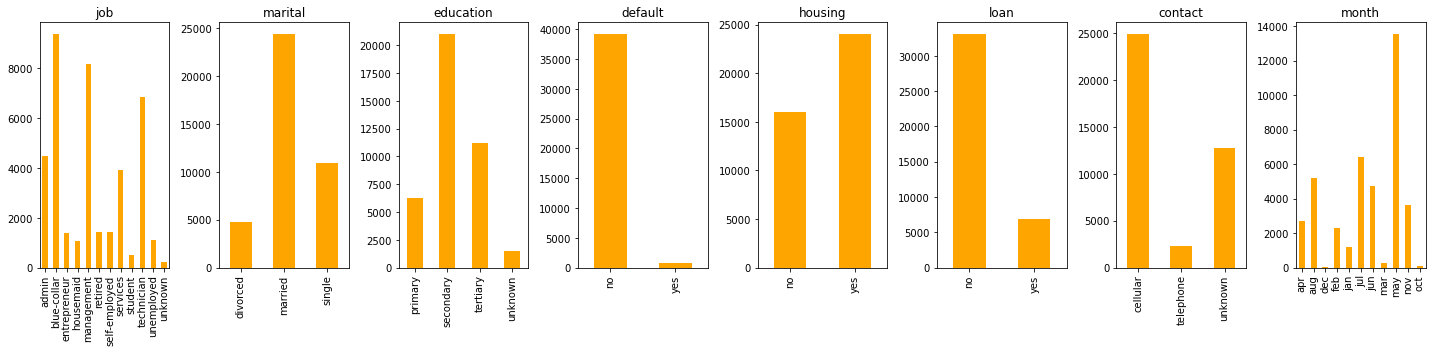

In [40]:
# Exploring the distribution of the data via histograms
fig, axes = plt.subplots(ncols = len(categorical), figsize=(20,5))
for col, ax in zip(categorical, axes):
    data[col].value_counts().sort_index().plot.bar(ax=ax, title=col, color=['orange'])

plt.tight_layout()    
plt.show()

In [41]:
# Checking for null data
data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

In [42]:
# the value 'unknown' in the attributes job, education and contact are essentially missing values 
# and can be replaced with NANs to future impute them

In [43]:
# we can impute unknown here with a random value given the relative small number of missing values
data["job"].value_counts()

blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: job, dtype: int64

In [44]:
data["job"].replace({"unknown": np.nan}, inplace=True)

In [45]:
# we can impute unknown here with with the mode
data["education"].value_counts()

secondary    20993
tertiary     11206
primary       6270
unknown       1531
Name: education, dtype: int64

In [46]:
data["education"].replace({"unknown": np.nan}, inplace=True)

In [47]:
# leaving the unkown value as is since it is high in number
data["contact"].value_counts()

cellular     24914
unknown      12765
telephone     2321
Name: contact, dtype: int64

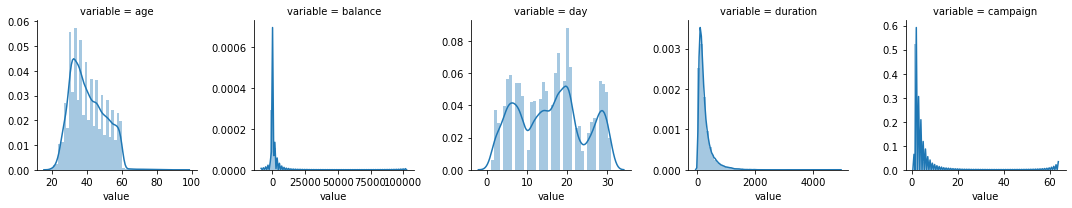

In [48]:
# Checking the distribution of the continuous variables via distplots
nd = pd.melt(data, value_vars = continuous)
n1 = sns.FacetGrid (nd, col = 'variable', col_wrap = 5, sharex = False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1

In [49]:
data.skew(axis = 0, skipna = True).sort_values(ascending=False)

balance     8.259236
campaign    4.730901
duration    3.165307
age         0.436080
day         0.067930
dtype: float64

#### Correlation Matrix

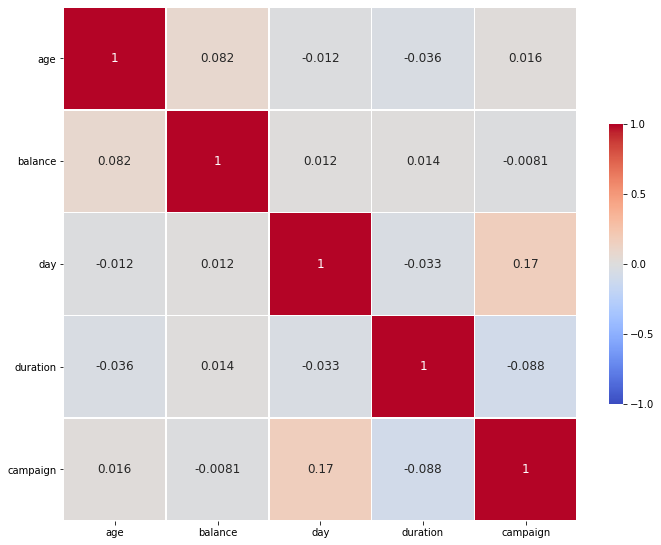

In [50]:
mask = np.zeros_like(data.corr(), dtype=np.bool)
f, ax = plt.subplots(figsize = (10,10)) 
heatmap = sns.heatmap(data.corr(), 
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 12})

ax.set_yticklabels(data.corr().columns, rotation = 0)
ax.set_xticklabels(data.corr().columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
plt.tight_layout()

In [51]:
# We don't really see much of a linear relation between the numerical columns in the data

In [52]:
data["y"].value_counts()

no     37104
yes     2896
Name: y, dtype: int64

In [6]:
data["y"].replace({"yes": 1 , "no": 0}, inplace=True)

#### Splitting the Data

In [326]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [7]:
data.shape

(40000, 14)

In [90]:
data = data.sample(frac = 0.3, replace = False, random_state = 1)

In [91]:
data.shape

(12000, 14)

In [8]:
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(data.drop('y',axis=1), data.y , test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=0)

#### Preprocessing Pipeline

In [11]:
prep_pipe = Pipeline([
    # Imputers
    ('rand_imputer', RandomSampleImputer(random_state = 40,
                                         seed = 'general',
                                         variables = ['job'])),
    
    ('mode_imputer', CategoricalVariableImputer(imputation_method='frequent',
                                                variables = ['education'])),
    # Encoder
    ('onehot_encoder', OneHotCategoricalEncoder(variables = categorical,
                                                top_categories = None,
                                                drop_last = True)),
    # Transformer
    ('yjt', YeoJohnsonTransformer(variables = continuous)),
    
    # Discretiser
    ('ew_disc', EqualWidthDiscretiser(bins=10, variables = continuous)),
    
    # Scaling
    ("standardscaler" , StandardScaler(with_mean=True, with_std=False)),
    ("robustscaler" , RobustScaler(with_centering=False, with_scaling=True, quantile_range=(0, 100))) 
    ])

In [12]:
prep_pipe.fit(X_train, y_train)
X_train = prep_pipe.transform(X_train)
X_val = prep_pipe.transform(X_val)
X_test = prep_pipe.transform(X_test)

### Selecting an optimal metric

- The specified goal requires us to choose the model based on the metric accuracy.
- Using accuracy as the metric is not optimal to making the best prediction especially due to the fact that our data set is imbalanced
- For Ex: Suppose we have 80% of the data points of just class A ; we can achieve 80% accuracy by just making every prediction A

In [31]:
data['y'].value_counts()

0    11150
1      850
Name: y, dtype: int64

- To achieve an optimal result we would like to maximize two components:

(1) The "True Positive Rate" aka Sensitivity aka Recall. Given by: TP/(TP+FN)


(2) The Precision - How many of the positive predictions, are in fact correct. Given by: TP/(TP+FP)

- To obtain a balance between both we use F Measure which is given by: (2 x Precision x Recall)/(Precision+Recall)

In [60]:
#creating a scorer for F2 score so that we can given an emphases on the minority class predictions
from sklearn.metrics import fbeta_score, make_scorer
f2score = make_scorer(fbeta_score, beta=2)
f2score

make_scorer(fbeta_score, beta=2)

### Model Training

#### Basic Models

##### Logistic Regression (L2 Penalty)

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
logreg_l2 = LogisticRegression(max_iter=10000, random_state=42)

logreg_param = {'penalty':['l2'],
                'dual':[False],
                'C':[0.001, 0.01, 0.1, 0.2, 0.5], 
                'fit_intercept':[True,False],
                'solver':['sag'],
                'warm_start':[True,False]}

logreg_l2_grid = GridSearchCV(logreg_l2, logreg_param, cv = 5, return_train_score=True, scoring = f2score)
logreg_l2_grid.fit(X_train,y_train)

print("Best Parameters for Logistic Regression: ",logreg_l2_grid.best_params_)

print("Best Mean Cross-validation score: {:.2f}".format(logreg_l2_grid.best_score_))

print("Test Performance: {:.2f} ".format(logreg_l2_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(logreg_l2_grid.score(X_val,y_val)))

Best Parameters for Logistic Regression:  {'C': 0.5, 'dual': False, 'fit_intercept': False, 'penalty': 'l2', 'solver': 'sag', 'warm_start': True}
Best Mean Cross-validation score: 0.47
Test Performance: 0.47 
Validation Performance: 0.47 


##### Logistic Regression (L1 Penalty)

In [48]:
logreg_l1 = LogisticRegression(max_iter=10000, random_state=42)

logreg_param = {'penalty':['l1'],
                'dual':[False],
                'C':[0.001, 0.01, 0.1, 0.2, 0.5], 
                'fit_intercept':[True,False],
                'solver':['liblinear'],
                'warm_start':[True]}

logreg_l1_grid = GridSearchCV(logreg_l1, logreg_param, cv = 5, return_train_score=True, scoring = f2score)
logreg_l1_grid.fit(X_train,y_train)

print("Best Parameters for Logistic Regression: ",logreg_l1_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(logreg_l1_grid.best_score_), '\n')

print("Test Performance: {:.2f} ".format(logreg_l1_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(logreg_l1_grid.score(X_val,y_val)))

Best Parameters for Logistic Regression:  {'C': 0.5, 'dual': False, 'fit_intercept': False, 'penalty': 'l1', 'solver': 'liblinear', 'warm_start': True} 

Best Mean Cross-validation score: 0.50 

Test Performance: 0.48 
Validation Performance: 0.48 


##### Logistic Regression (Elastic Penalty)

In [52]:
logreg_l1 = LogisticRegression(max_iter=10000, random_state=42)

logreg_param = {'penalty':['elasticnet'],
                'dual':[False],
                'C':[0.001, 0.01, 0.1, 0.2, 0.5], 
                'fit_intercept':[True,False],
                'solver':['saga'],
                'warm_start':[True],
                'l1_ratio':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
                'class_weight':[None,'balanced'],}

logreg_l1_grid = GridSearchCV(logreg_l1, logreg_param, cv = 5, return_train_score=True, scoring= f2score)
logreg_l1_grid.fit(X_train,y_train)

print("Best Parameters: ",logreg_l1_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(logreg_l1_grid.best_score_), '\n')

print("Test Performance: {:.2f} ".format(logreg_l1_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(logreg_l1_grid.score(X_val,y_val)))

Best Parameters:  {'C': 0.1, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'l1_ratio': 0.8, 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True} 

Best Mean Cross-validation score: 0.63 

Test Performance: 0.61 
Validation Performance: 0.62 


##### KNN 

In [46]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

param_knn = {'n_neighbors': range(5,25), 
             'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
             'weights':['uniform','distance']}

grid_knn = GridSearchCV(knn, param_knn, cv = 5, return_train_score = True, scoring = f2score)
grid_knn.fit(X_train, y_train)

print("Best Parameters: ",grid_knn.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(grid_knn.best_score_), '\n')

print("Test Performance: {:.2f} ".format(grid_knn.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(grid_knn.score(X_val,y_val)))

Best Parameters for Logistic Regression:  {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'}
Best Mean Cross-validation score: 0.14 

Test Performance: 0.17 
Validation Performance: 0.15 


##### Decision Tree

In [49]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=0)

param_dtree = {"max_depth": [1,2,3,4,5,7,9],
           "min_samples_split": [2,3,4],
           "max_leaf_nodes": [3,4,5],
           "criterion":['gini'],
           "splitter":['best','random']}

grid_dtree = GridSearchCV(dtree, param_dtree, cv = 5, return_train_score = True, scoring = f2score)
grid_dtree.fit(X_train, y_train)

print("Best Parameters: ",grid_dtree.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(grid_dtree.best_score_), '\n')

print("Test Performance: {:.2f} ".format(grid_dtree.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(grid_dtree.score(X_val,y_val)))

Best Parameters for Logistic Regression:  {'criterion': 'gini', 'max_depth': 2, 'max_leaf_nodes': 4, 'min_samples_split': 2, 'splitter': 'random'} 

Best Mean Cross-validation score: 0.37 

Test Performance: 0.37 
Validation Performance: 0.34 


##### Linear SVC

In [53]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC(random_state=42)

param = [{'penalty':['l2'],
          'C': [0.001, 0.002, 0.0001, 0.008, 0.01, 0.1], 
          'loss':['hinge','squared_hinge']}]

svc_grid = GridSearchCV(lsvc, param, cv = 5 ,return_train_score = True ,scoring = f2score)
svc_grid.fit(X_train, y_train)

print("Best Parameters: ",svc_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(svc_grid.best_score_), '\n')

print("Test Performance: {:.2f} ".format(svc_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(svc_grid.score(X_val,y_val)))

Best Parameters:  {'C': 0.1, 'loss': 'squared_hinge', 'penalty': 'l2'} 

Best Mean Cross-validation score: 0.18 

Test Performance: 0.21 
Validation Performance: 0.17 


##### Kernel SVC

In [51]:
from sklearn.svm import SVC
svc = SVC()
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['poly'],
               'degree': [2, 3, 4, 5, 6]},
              {'kernel': ['sigmoid'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}]

svm_grid = GridSearchCV(svc, param_grid, cv = 5 ,return_train_score = True ,scoring = f2score)
svm_grid.fit(X_train, y_train)

print("Best Parameters: ",svm_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(svm_grid.best_score_), '\n')

print("Test Performance: {:.2f} ".format(svm_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(svm_grid.score(X_val,y_val)))

Best Parameters:  {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'} 

Best Mean Cross-validation score: 0.36 

Test Performance: 0.37 
Validation Performance: 0.36 


##### SGD Classifier

In [54]:
from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier(random_state=42)
sgdc_param = {'penalty': ['l2', 'l1','elasticnet'],
              'l1_ratio': [0.1,0.3,0.5,0.7,0.9],
              'alpha': [0.0001, 0.001, 0.01, 0.02, 0.05, 1, 10],
              'fit_intercept': [True, False],
              'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
              'eta0': [0.001, 0.01,0.05,0.1,0.2,0.3,0.4,0.5]
                     }    

sgdc_grid = GridSearchCV(sgdc, sgdc_param, cv = 5, return_train_score = True, scoring = f2score)
sgdc_grid.fit(X_train, y_train)

print("Best Parameters: ",sgdc_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(sgdc_grid.best_score_), '\n')

print("Test Performance: {:.2f} ".format(sgdc_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(sgdc_grid.score(X_val,y_val)))

Best Parameters:  {'alpha': 0.0001, 'eta0': 0.1, 'fit_intercept': False, 'l1_ratio': 0.7, 'learning_rate': 'adaptive', 'penalty': 'elasticnet'} 

Best Mean Cross-validation score: 0.58 

Test Performance: 0.56 
Validation Performance: 0.58 


##### LDA

In [58]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

param_grid = {'solver' : ['lsqr', 'eigen'],
              'shrinkage': [None, 0.0001, 0.001, 0.01, 0.0005, 0.005, 0.05, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}    

lda_grid = GridSearchCV(LinearDiscriminantAnalysis(), param_grid, cv = 5, scoring = f2score, return_train_score = True)

lda_grid.fit(X_train,y_train)

print("Best Parameters: ",lda_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(lda_grid.best_score_), '\n')

print("Test Performance: {:.2f} ".format(lda_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(lda_grid.score(X_val,y_val)))

Best Parameters:  {'shrinkage': None, 'solver': 'lsqr'} 

Best Mean Cross-validation score: 0.27 

Test Performance: 0.31 
Validation Performance: 0.25 


##### MLP Classifier

In [59]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(hidden_layer_sizes=(12, 8, 4), max_iter = 500, random_state = 42)
param = {}

mlp_grid= GridSearchCV(mlpc, param, cv = 10, return_train_score = True, scoring = f2score)
mlp_clf = mlp_grid.fit(X_train,y_train)

print("Best Mean Cross-validation score: {:.2f}".format(mlp_clf.best_score_), '\n')

print("Test Performance: {:.2f} ".format(mlp_clf.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(mlp_clf.score(X_val,y_val)))

Best Mean Cross-validation score: 0.44 

Test Performance: 0.43 
Validation Performance: 0.41 


#### Ensemble Models

##### Bagging with DTree

In [62]:
from sklearn.ensemble import BaggingClassifier
bag_dtree1 = BaggingClassifier(base_estimator=DecisionTreeClassifier(), bootstrap = True, 
                               random_state=0, oob_score = False)

bag_dtree1_param = {
                 'base_estimator__max_depth': [1,2,3,4,5,7,9],
                 'base_estimator__max_leaf_nodes': [2,3,4,5],
                 'base_estimator__min_samples_split':[2,3,4],
                 'base_estimator__criterion':['gini','entropy'],
                 'max_samples':  [0.8,1],
                 'n_estimators': [50,100,200]}

bag_dtree1_grid = GridSearchCV(bag_dtree1, bag_dtree1_param,cv = 5, return_train_score = True, scoring = f2score)
bag_dtree1_grid.fit(X_train,y_train)

print("Best Parameters: ",bag_dtree1_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(bag_dtree1_grid.best_score_), '\n')

print("Test Performance: {:.2f} ".format(bag_dtree1_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(bag_dtree1_grid.score(X_val,y_val)))

Best Parameters:  {'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 2, 'base_estimator__max_leaf_nodes': 4, 'base_estimator__min_samples_split': 2, 'max_samples': 0.8, 'n_estimators': 50} 

Best Mean Cross-validation score: 0.35 

Test Performance: 0.34 
Validation Performance: 0.32 


##### Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state = 42)
rfc_param = {'n_estimators': [200, 500],
            'max_features': ['auto'],
            'max_depth' : [2,4,6,8,9],
            'criterion' :['gini', 'entropy'],
            'min_samples_split':[2,3,4,6,8],
            'min_samples_leaf': [1,2,3,4]}

rfc_grid = GridSearchCV(rfc, rfc_param,cv = 5, return_train_score = True, scoring = f2score)
rfc_grid.fit(X_train,y_train)

print("Best Parameters: ",rfc_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(rfc_grid.best_score_), '\n')

print("Test Performance: {:.2f} ".format(rfc_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(rfc_grid.score(X_val,y_val)))

Best Parameters:  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 200} 

Best Mean Cross-validation score: 0.02 

Test Performance: 0.03 
Validation Performance: 0.02 


##### Gradient Boosting Classifier

In [30]:
from  sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
gbc= GradientBoostingClassifier(random_state = 42)
gbc_param = {
              'min_samples_split':[2,3],
              'subsample':[0.6,0.8,1],
              'min_samples_leaf':[1,2],
              'max_depth' : [2,3,4,7],
              'n_estimators' : [100,150],
              'learning_rate' : [0.5,1.0,2]
             }

gbc_grid = RandomizedSearchCV(gbc, gbc_param,cv = 5, return_train_score = True, scoring = f2score)
gbc_grid.fit(X_train,y_train)
print("Best Parameters: ",gbc_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(gbc_grid.best_score_), '\n')

print("Test Performance: {:.2f} ".format(gbc_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(gbc_grid.score(X_val,y_val)))

Best Parameters:  {'subsample': 0.6, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.5} 

Best Mean Cross-validation score: 0.40 

Test Performance: 0.42 
Validation Performance: 0.40 


##### XGBoost Classifier

In [31]:
from xgboost import XGBClassifier
xgbc= XGBClassifier(random_state = 42,early_stopping_rounds=2,objective= 'binary:logistic')

xgbc_param = {
              'max_depth' : [2,5,7],
              'n_estimators' : [100,150,300],
              'learning_rate' : [0.5,1,2],
              'gamma' : [0.5,1.0,2],
              'min_child_weight' : [1,2],
              'subsample':[0.8,1],
              'colsample_bytree':[0.6,0.8],
              'lambda':[0.1,0.5,1],
              'alpha':[0.1,0.5,1]
             }

xgbc_grid = RandomizedSearchCV(xgbc, xgbc_param,cv = 5, return_train_score = True, scoring = f2score)
xgbc_grid.fit(X_train,y_train)
print("Best Parameters: ",xgbc_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(xgbc_grid.best_score_), '\n')

print("Test Performance: {:.2f} ".format(xgbc_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(xgbc_grid.score(X_val,y_val)))

Best Parameters:  {'subsample': 1, 'n_estimators': 150, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 1, 'lambda': 1, 'gamma': 2, 'colsample_bytree': 0.8, 'alpha': 1} 

Best Mean Cross-validation score: 0.41 

Test Performance: 0.43 
Validation Performance: 0.40 


##### CATBoost Classsifier

In [ ]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier()

param_grid = {
            'depth':[7,9,10,11,12],
            'iterations':[500,750,1000], 
            'learning_rate':[0.2,0.25,0.3,0.4], 
            'l2_leaf_reg':[7,8,9,10,15], 
            'border_count':[4,5,6,7,8]
                      }

cat_grid = RandomizedSearchCV(cat, param_grid, cv = 10, return_train_score = True, scoring = f2score)
cat_grid.fit(X_train,y_train)

print("Best Parameters: ",cat_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(cat_grid.best_score_), '\n')

print("Test Performance: {:.2f} ".format(cat_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(cat_grid.score(X_val,y_val)))

Best Parameters:  {'learning_rate': 0.25, 'l2_leaf_reg': 9, 'iterations': 750, 'depth': 9, 'border_count': 5} 
{'learning_rate': 0.3, 'l2_leaf_reg': 10, 'iterations': 1000, 'depth': 7, 'border_count': 5}

Best Mean Cross-validation score: 0.42 

Test Performance: 0.42 
Validation Performance: 0.40 

##### LightGBM Classifier

In [43]:
import lightgbm as lgb
param_grid = {'num_leaves': [10,20,30,40,50,60,70,80,90,100,150,200],
              'max_depth': [4,5,6,7,8,9,10,11,12,13,14,15],
              'learning_rate': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
              'n_estimators': [10, 30, 50, 70, 90, 100, 120, 150, 170, 200], 
              'min_split_gain' : [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
              'reg_alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
              'reg_lambda': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

mdl = lgb.LGBMClassifier(random_state = 42,
                         objective = 'binary')

lgbm_grid = RandomizedSearchCV(mdl, param_grid, cv = 5, return_train_score = True, scoring = f2score)
lgbm_grid.fit(X_train,y_train)

print("Best Parameters: ",lgbm_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(lgbm_grid.best_score_), '\n')

print("Test Performance: {:.2f} ".format(lgbm_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(lgbm_grid.score(X_val,y_val)))

Best Parameters:  {'reg_lambda': 0.3, 'reg_alpha': 0.5, 'num_leaves': 200, 'n_estimators': 100, 'min_split_gain': 0.7, 'max_depth': 7, 'learning_rate': 0.9} 

Best Mean Cross-validation score: 0.41 

Test Performance: 0.43 
Validation Performance: 0.46 


#### Cost Sensitive Algorithms

The idea behind using Cost Sensitive Algorithms is to given varying weights to each of the classes while building the model in an effort to built better predictors

##### Logistic Regression

In [46]:
#cost sensitive logistic regession L2
param_grid = {
    'penalty':['l2'],
    'dual':[False],
    'C':[0.001, 0.01, 0.1, 0.2, 0.5], 
    'fit_intercept':[True,False],
    'solver':['sag'],
    'warm_start':[True,False],
    'class_weight': [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
}
#apply grid search
cgrid_logreg = GridSearchCV(LogisticRegression(random_state = 42, max_iter = 10000),
                           param_grid, cv = 5, n_jobs = -1, scoring = f2score)
cgrid_logreg.fit(X_train, y_train)

print("Best Parameters: ",cgrid_logreg.best_params_, '\n')
print("Best Mean Cross-validation score: {:.2f}".format(cgrid_logreg.best_score_), '\n')

print("Test Performance: {:.2f} ".format(cgrid_logreg.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(cgrid_logreg.score(X_val,y_val)))

Best Parameters:  {'C': 0.2, 'class_weight': {0: 1, 1: 10}, 'dual': False, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'sag', 'warm_start': True} 

Best Mean Cross-validation score: 0.63 

Test Performance: 0.61 
Validation Performance: 0.62 


In [35]:
# cost sensitive logistic regession elasticnet
param_grid = {'penalty':['elasticnet'],
                'dual':[False],
                'C':[0.01, 0.1, 0.2, 0.5], 
                'fit_intercept':[True,False],
                'solver':['saga'],
                'warm_start':[True],
                'l1_ratio':[0.4,0.7,0.8,0.9],
                'class_weight': [{0:1,1:1}, {0:1,1:5}, {0:1,1:10}, {0:1,1:100}]}

cgrid_logreg = RandomizedSearchCV(LogisticRegression(random_state = 42, max_iter = 100000),
                            param_grid, cv = 5, n_jobs = -1, scoring = f2score)
cgrid_logreg.fit(X_train, y_train)

print("Best Parameters: ",cgrid_logreg.best_params_, '\n')
print("Best Mean Cross-validation score: {:.2f}".format(cgrid_logreg.best_score_), '\n')

print("Test Performance: {:.2f} ".format(cgrid_logreg.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(cgrid_logreg.score(X_val,y_val)))

Best Parameters:  {'warm_start': True, 'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.8, 'fit_intercept': False, 'dual': False, 'class_weight': {0: 1, 1: 10}, 'C': 0.5} 

Best Mean Cross-validation score: 0.45 

Test Performance: 0.46 
Validation Performance: 0.45 


##### Kernel Support Vector Machine

In [32]:
from sklearn.svm import SVC
svc = SVC()
param_grid = {'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
               'class_weight': [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
             }

cs_svm_grid = RandomizedSearchCV(svc, param_grid, cv = 5 ,return_train_score = True ,scoring = f2score)
cs_svm_grid.fit(X_train, y_train)

print("Best Parameters: ",cs_svm_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(cs_svm_grid.best_score_), '\n')

print("Test Performance: {:.2f} ".format(cs_svm_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(cs_svm_grid.score(X_val,y_val)))

Best Parameters:  {'kernel': 'rbf', 'gamma': 0.01, 'class_weight': {0: 1, 1: 10}, 'C': 0.1} 

Best Mean Cross-validation score: 0.55 

Test Performance: 0.55 
Validation Performance: 0.55 


##### SGDClassifier

In [37]:
from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier(random_state=42)
sgdc_param = {
    'penalty': ['elasticnet'],
    'class_weight': [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
}    

cs_sgdc_grid = GridSearchCV(sgdc, sgdc_param, cv = 5, return_train_score = True, scoring = f2score)
cs_sgdc_grid.fit(X_train, y_train)

print("Best Parameters: ",cs_sgdc_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(cs_sgdc_grid.best_score_), '\n')

print("Test Performance: {:.2f} ".format(cs_sgdc_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(cs_sgdc_grid.score(X_val,y_val)))

Best Parameters:  {'class_weight': {0: 1, 1: 10}, 'penalty': 'elasticnet'} 

Best Mean Cross-validation score: 0.62 

Test Performance: 0.59 
Validation Performance: 0.61 


##### LightGBM

In [68]:
import lightgbm as lgb
param_grid = { 
'class_weight': [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}],
}

lgb_cs = GridSearchCV(lgb.LGBMClassifier(), 
                         param_grid, cv = 5, n_jobs = 2, scoring = f2score)


lgb_cs.fit(X_train, y_train)
print("Best Parameters: ",lgb_cs.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(lgb_cs.best_score_), '\n')

print("Test Performance: {:.2f} ".format(lgb_cs.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(lgb_cs.score(X_val,y_val)))

Best Parameters:  {'class_weight': {0: 1, 1: 100}} 

Best Mean Cross-validation score: 0.65 

Test Performance: 0.65 
Validation Performance: 0.66 


##### XGBoost

In [59]:
from xgboost import XGBClassifier
param_grid = { 
    'scale_pos_weight': [1, 2, 10, 25, 50, 75, 99, 100],
}
cgrid_xgboost= GridSearchCV(XGBClassifier(), param_grid, cv = 5, n_jobs = -1, scoring = f2score)
cgrid_xgboost.fit(X_train, y_train)

print("Best Parameters: ",cgrid_xgboost.best_params_, '\n')
print("Best Mean Cross-validation score: {:.2f}".format(cgrid_xgboost.best_score_), '\n')

print("Test Performance: {:.2f} ".format(cgrid_xgboost.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(cgrid_xgboost.score(X_val,y_val)))

Best Parameters:  {'scale_pos_weight': 99} 

Best Mean Cross-validation score: 0.57 

Test Performance: 0.64 
Validation Performance: 0.60 


##### CatBoost

In [64]:
from catboost import CatBoostClassifier
# param_grid = { 
# 'depth':[7,9],
# 'class_weights' : [[100,1], [10,80], [70,1], [1,1], [1,10], [1,100], [1,50]]
# }
param_grid = { 
'depth':[7],
'class_weights' : [[1,100]]
}

cat_grid_cs = GridSearchCV(CatBoostClassifier(border_count = 5, iterations = 1000, l2_leaf_reg = 10, 
                                              learning_rate = 0.3), 
                           param_grid, cv=5, n_jobs = -1, scoring = f2score)

cat_grid_cs.fit(X_train, y_train)

print("Best Parameters: ",cat_grid_cs.best_params_, '\n')
print("Best Mean Cross-validation score: {:.2f}".format(cat_grid_cs.best_score_), '\n')

print("Test Performance: {:.2f} ".format(cat_grid_cs.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(cat_grid_cs.score(X_val,y_val)))

prediction_test = cat_grid_cs.predict(X_test)
prediction_val = cat_grid_cs.predict(X_val)

0:	learn: 0.4335060	total: 33.3ms	remaining: 33.3s
1:	learn: 0.3430652	total: 55ms	remaining: 27.5s
2:	learn: 0.2655823	total: 87.6ms	remaining: 29.1s
3:	learn: 0.2263241	total: 112ms	remaining: 28s
4:	learn: 0.2061110	total: 138ms	remaining: 27.5s
5:	learn: 0.1948984	total: 165ms	remaining: 27.4s
6:	learn: 0.1886172	total: 188ms	remaining: 26.6s
7:	learn: 0.1774689	total: 214ms	remaining: 26.6s
8:	learn: 0.1744844	total: 255ms	remaining: 28.1s
9:	learn: 0.1664446	total: 293ms	remaining: 29s
10:	learn: 0.1596847	total: 341ms	remaining: 30.6s
11:	learn: 0.1561008	total: 367ms	remaining: 30.3s
12:	learn: 0.1503000	total: 390ms	remaining: 29.6s
13:	learn: 0.1473679	total: 422ms	remaining: 29.7s
14:	learn: 0.1458112	total: 460ms	remaining: 30.2s
15:	learn: 0.1442685	total: 501ms	remaining: 30.8s
16:	learn: 0.1436759	total: 550ms	remaining: 31.8s
17:	learn: 0.1425612	total: 586ms	remaining: 31.9s
18:	learn: 0.1405727	total: 616ms	remaining: 31.8s
19:	learn: 0.1396273	total: 665ms	remaining:

163:	learn: 0.0818906	total: 5.34s	remaining: 27.2s
164:	learn: 0.0818889	total: 5.38s	remaining: 27.2s
165:	learn: 0.0818872	total: 5.4s	remaining: 27.1s
166:	learn: 0.0818857	total: 5.43s	remaining: 27.1s
167:	learn: 0.0818842	total: 5.45s	remaining: 27s
168:	learn: 0.0818829	total: 5.48s	remaining: 26.9s
169:	learn: 0.0818816	total: 5.5s	remaining: 26.9s
170:	learn: 0.0818803	total: 5.54s	remaining: 26.9s
171:	learn: 0.0818791	total: 5.57s	remaining: 26.8s
172:	learn: 0.0818780	total: 5.59s	remaining: 26.7s
173:	learn: 0.0818770	total: 5.62s	remaining: 26.7s
174:	learn: 0.0818759	total: 5.67s	remaining: 26.7s
175:	learn: 0.0818750	total: 5.69s	remaining: 26.6s
176:	learn: 0.0818741	total: 5.71s	remaining: 26.5s
177:	learn: 0.0818732	total: 5.73s	remaining: 26.5s
178:	learn: 0.0818723	total: 5.75s	remaining: 26.4s
179:	learn: 0.0818572	total: 5.78s	remaining: 26.3s
180:	learn: 0.0818564	total: 5.82s	remaining: 26.3s
181:	learn: 0.0816567	total: 5.85s	remaining: 26.3s
182:	learn: 0.08

324:	learn: 0.0696301	total: 9.65s	remaining: 20.1s
325:	learn: 0.0696298	total: 9.68s	remaining: 20s
326:	learn: 0.0696295	total: 9.73s	remaining: 20s
327:	learn: 0.0696286	total: 9.75s	remaining: 20s
328:	learn: 0.0694392	total: 9.79s	remaining: 20s
329:	learn: 0.0693467	total: 9.81s	remaining: 19.9s
330:	learn: 0.0691678	total: 9.85s	remaining: 19.9s
331:	learn: 0.0690610	total: 9.89s	remaining: 19.9s
332:	learn: 0.0689946	total: 9.92s	remaining: 19.9s
333:	learn: 0.0689190	total: 9.95s	remaining: 19.8s
334:	learn: 0.0688484	total: 9.97s	remaining: 19.8s
335:	learn: 0.0688450	total: 10s	remaining: 19.8s
336:	learn: 0.0688445	total: 10s	remaining: 19.7s
337:	learn: 0.0687621	total: 10s	remaining: 19.7s
338:	learn: 0.0687594	total: 10.1s	remaining: 19.6s
339:	learn: 0.0687570	total: 10.1s	remaining: 19.6s
340:	learn: 0.0687560	total: 10.1s	remaining: 19.5s
341:	learn: 0.0687557	total: 10.1s	remaining: 19.5s
342:	learn: 0.0687537	total: 10.1s	remaining: 19.4s
343:	learn: 0.0687534	tota

486:	learn: 0.0631449	total: 14.4s	remaining: 15.2s
487:	learn: 0.0631426	total: 14.5s	remaining: 15.2s
488:	learn: 0.0631406	total: 14.5s	remaining: 15.2s
489:	learn: 0.0630725	total: 14.5s	remaining: 15.1s
490:	learn: 0.0630704	total: 14.6s	remaining: 15.1s
491:	learn: 0.0630685	total: 14.6s	remaining: 15.1s
492:	learn: 0.0630666	total: 14.6s	remaining: 15s
493:	learn: 0.0630649	total: 14.6s	remaining: 15s
494:	learn: 0.0630633	total: 14.7s	remaining: 15s
495:	learn: 0.0630618	total: 14.7s	remaining: 14.9s
496:	learn: 0.0630603	total: 14.7s	remaining: 14.9s
497:	learn: 0.0630589	total: 14.7s	remaining: 14.9s
498:	learn: 0.0630008	total: 14.8s	remaining: 14.9s
499:	learn: 0.0629992	total: 14.8s	remaining: 14.8s
500:	learn: 0.0629978	total: 14.8s	remaining: 14.8s
501:	learn: 0.0629965	total: 14.9s	remaining: 14.7s
502:	learn: 0.0629953	total: 14.9s	remaining: 14.7s
503:	learn: 0.0629941	total: 14.9s	remaining: 14.7s
504:	learn: 0.0629931	total: 14.9s	remaining: 14.6s
505:	learn: 0.0629

654:	learn: 0.0620764	total: 18.5s	remaining: 9.72s
655:	learn: 0.0620762	total: 18.5s	remaining: 9.69s
656:	learn: 0.0620754	total: 18.5s	remaining: 9.65s
657:	learn: 0.0620753	total: 18.5s	remaining: 9.62s
658:	learn: 0.0620751	total: 18.5s	remaining: 9.58s
659:	learn: 0.0620746	total: 18.5s	remaining: 9.55s
660:	learn: 0.0620744	total: 18.6s	remaining: 9.51s
661:	learn: 0.0620743	total: 18.6s	remaining: 9.48s
662:	learn: 0.0620741	total: 18.6s	remaining: 9.45s
663:	learn: 0.0620738	total: 18.6s	remaining: 9.41s
664:	learn: 0.0620737	total: 18.6s	remaining: 9.38s
665:	learn: 0.0620736	total: 18.6s	remaining: 9.35s
666:	learn: 0.0620734	total: 18.7s	remaining: 9.31s
667:	learn: 0.0620732	total: 18.7s	remaining: 9.28s
668:	learn: 0.0620730	total: 18.7s	remaining: 9.25s
669:	learn: 0.0620728	total: 18.7s	remaining: 9.21s
670:	learn: 0.0620727	total: 18.7s	remaining: 9.18s
671:	learn: 0.0620725	total: 18.7s	remaining: 9.15s
672:	learn: 0.0619429	total: 18.8s	remaining: 9.12s
673:	learn: 

814:	learn: 0.0612613	total: 21.6s	remaining: 4.89s
815:	learn: 0.0612609	total: 21.6s	remaining: 4.87s
816:	learn: 0.0612606	total: 21.6s	remaining: 4.84s
817:	learn: 0.0612602	total: 21.7s	remaining: 4.82s
818:	learn: 0.0612599	total: 21.7s	remaining: 4.8s
819:	learn: 0.0612596	total: 21.7s	remaining: 4.77s
820:	learn: 0.0612593	total: 21.7s	remaining: 4.74s
821:	learn: 0.0612590	total: 21.8s	remaining: 4.71s
822:	learn: 0.0612587	total: 21.8s	remaining: 4.69s
823:	learn: 0.0612584	total: 21.8s	remaining: 4.66s
824:	learn: 0.0612581	total: 21.9s	remaining: 4.64s
825:	learn: 0.0612578	total: 21.9s	remaining: 4.61s
826:	learn: 0.0612575	total: 21.9s	remaining: 4.58s
827:	learn: 0.0612573	total: 21.9s	remaining: 4.55s
828:	learn: 0.0612570	total: 21.9s	remaining: 4.52s
829:	learn: 0.0612568	total: 22s	remaining: 4.5s
830:	learn: 0.0612565	total: 22s	remaining: 4.47s
831:	learn: 0.0612563	total: 22s	remaining: 4.44s
832:	learn: 0.0612561	total: 22s	remaining: 4.41s
833:	learn: 0.0612558	

973:	learn: 0.0608823	total: 25.7s	remaining: 686ms
974:	learn: 0.0608823	total: 25.7s	remaining: 660ms
975:	learn: 0.0608823	total: 25.7s	remaining: 633ms
976:	learn: 0.0608823	total: 25.8s	remaining: 606ms
977:	learn: 0.0607577	total: 25.8s	remaining: 580ms
978:	learn: 0.0607575	total: 25.8s	remaining: 554ms
979:	learn: 0.0607573	total: 25.9s	remaining: 528ms
980:	learn: 0.0607572	total: 25.9s	remaining: 501ms
981:	learn: 0.0607572	total: 25.9s	remaining: 475ms
982:	learn: 0.0607572	total: 25.9s	remaining: 448ms
983:	learn: 0.0607571	total: 25.9s	remaining: 421ms
984:	learn: 0.0607571	total: 25.9s	remaining: 395ms
985:	learn: 0.0607570	total: 26s	remaining: 369ms
986:	learn: 0.0607569	total: 26s	remaining: 343ms
987:	learn: 0.0607568	total: 26s	remaining: 316ms
988:	learn: 0.0607568	total: 26.1s	remaining: 290ms
989:	learn: 0.0607567	total: 26.1s	remaining: 263ms
990:	learn: 0.0607567	total: 26.1s	remaining: 237ms
991:	learn: 0.0607566	total: 26.1s	remaining: 211ms
992:	learn: 0.0607

Best Parameters:  {'class_weights': [1, 100], 'depth': 7} 

Best Mean Cross-validation score: 0.63 

Test Performance: 0.65 

Validation Performance: 0.63 

In [ ]:
from catboost import CatBoostClassifier
# param_grid = { 
# 'depth':[7,9],
# 'class_weights' : [[100,1], [10,80], [70,1], [1,1], [1,10], [1,100], [1,50]]
# }
param_grid = { 
'depth':[7],
'class_weights' : [[1,100]]
}

cat_grid_cs = GridSearchCV(CatBoostClassifier(border_count = 5, iterations = 1000, l2_leaf_reg = 10, 
                                              learning_rate = 0.3), 
                           param_grid, cv=5, n_jobs = -1, scoring = f2score)

cat_grid_cs.fit(X_train, y_train)

print("Best Parameters: ",cat_grid_cs.best_params_, '\n')
print("Best Mean Cross-validation score: {:.2f}".format(cat_grid_cs.best_score_), '\n')

print("Test Performance: {:.2f} ".format(cat_grid_cs.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(cat_grid_cs.score(X_val,y_val)))

prediction_test = cat_grid_cs.predict(X_test)
prediction_val = cat_grid_cs.predict(X_val)

#### Data Sampling

The idea is to change the dataset used to build the models by:

1) Adding copies of instances from the under-represented class called over-sampling (via various SMOTE methods)

2) Deleting instances from the over-represented class, called under-sampling

In [36]:
from imblearn.pipeline import Pipeline

In [37]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline
from numpy import mean
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN

##### SGD Classifier

In [ ]:
# SMOTE and Undersampling

In [42]:
sgdc = Pipeline([('smote', SMOTE()),
                 ('under', RandomUnderSampler()),
                 ('sgdc', SGDClassifier(penalty = 'elasticnet', random_state = 42))])

param_sgdc = {'smote__k_neighbors': [1,2,3,4,5,7,10,12,15]}

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state=1)
sgdc_ds1 = GridSearchCV(sgdc,param_sgdc, cv = cv, n_jobs = -1, scoring=f2score)
sgdc_ds1.fit(X_train, y_train)

print("Best Parameters: ",sgdc_ds1.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(sgdc_ds1.best_score_), '\n')

print("Test Performance: {:.2f} ".format(sgdc_ds1.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(sgdc_ds1.score(X_val,y_val)))

Best Parameters:  {'smote__k_neighbors': 15} 

Best Mean Cross-validation score: 0.60 

Test Performance: 0.62 
Validation Performance: 0.63 


##### Logistic Regression

In [ ]:
# SMOTE and Undersampling

In [52]:
logreg = Pipeline([('smote', SMOTE()),
                 ('under', RandomUnderSampler()),
                 ('logistic', LogisticRegression(max_iter = 20000, random_state = 42))])

logreg_param = {'logistic__penalty':['elasticnet'],
                'logistic__dual':[False],
                'logistic__C':[0.01, 0.1, 0.2], 
                'logistic__fit_intercept':[True,False],
                'logistic__solver':['saga'],
                'logistic__warm_start':[True],
                'logistic__l1_ratio':[0.2,0.5,0.7,0.8],
                'smote__k_neighbors': [3,5,7,10]}

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
log_ds1 = GridSearchCV(logreg, logreg_param, cv = cv, n_jobs = -1, scoring = f2score)
log_ds1.fit(X_train, y_train)

print("Best Parameters: ",log_ds1.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(log_ds1.best_score_), '\n')

print("Test Performance: {:.2f} ".format(log_ds1.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(log_ds1.score(X_val,y_val)))

Best Parameters:  {'logistic__C': 0.1, 'logistic__dual': False, 'logistic__fit_intercept': True, 'logistic__l1_ratio': 0.8, 'logistic__penalty': 'elasticnet', 'logistic__solver': 'saga', 'logistic__warm_start': True, 'smote__k_neighbors': 5} 

Best Mean Cross-validation score: 0.61 

Test Performance: 0.63 
Validation Performance: 0.62 


##### XGBoost

In [71]:
xgb_pipe = Pipeline([('smote', SMOTE()),
                 ('under', RandomUnderSampler()),
                 ('xgb', XGBClassifier(alpha = 1, colsample_bytree = 0.8, gamma = 2, 
                                       learning_rate = 1, max_depth = 7, min_child_weight = 1, 
                                       n_estimators = 150, subsample = 1, objective='binary:logistic',
                                       random_state=42))])

param_xgb = {'smote__k_neighbors': [1,2,3,4,5,7,10,12,15]}

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)
xgb_ds = GridSearchCV(xgb_pipe, param_xgb, cv = cv, n_jobs = -1, scoring = f2score)
xgb_ds.fit(X_train, y_train)

print("Best Parameters: ",xgb_ds.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(xgb_ds.best_score_), '\n')

print("Test Performance: {:.2f} ".format(xgb_ds.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(xgb_ds.score(X_val,y_val)))

Best Parameters:  {'smote__k_neighbors': 7} 

Best Mean Cross-validation score: 0.44 

Test Performance: 0.47 
Validation Performance: 0.43 


#### Probabilty Calibration

##### SGD Classifier

In [73]:
from sklearn.calibration import CalibratedClassifierCV
model = SGDClassifier()

calibrated = CalibratedClassifierCV(model, method='sigmoid', cv = 5)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state = 1)

param = {}
sgd_pc_grid = GridSearchCV(calibrated, param, cv = cv, n_jobs = -1, scoring = f2score)

sgd_pc_grid.fit(X_train,y_train)
print("Best Mean Cross-validation score: {:.2f}".format(sgd_pc_grid.best_score_), '\n')

print("Test Performance: {:.2f} ".format(sgd_pc_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(sgd_pc_grid.score(X_val,y_val)))

Best Mean Cross-validation score: 0.21 

Test Performance: 0.24 
Validation Performance: 0.20 


##### XGBoost

In [105]:
from sklearn.calibration import CalibratedClassifierCV
model = XGBClassifier()
# wrap the model
calibrated = CalibratedClassifierCV(model, method='isotonic', cv=3)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
param = {}
# evaluate model
xgb_pc_grid= GridSearchCV(calibrated, param, cv=cv, n_jobs=-1, scoring=f2score)

xgb_pc = xgb_pc_grid.fit(X_train,y_train)

print("Best Mean Cross-validation score: {:.2f}".format(xgb_pc.best_score_), '\n')

print("Test Performance: {:.2f} ".format(xgb_pc.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(xgb_pc.score(X_val,y_val)))

Best Mean Cross-validation score: 0.20 

Test Performance: 0.17 
Validation Performance: 0.16 


### Results

Best Model - Cost Sensitive CatBoost Classifier

In [ ]:
## Assess Metrics
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
model = CatBoostClassifier(border_count = 5, iterations = 1000, l2_leaf_reg = 10, 
                          depth = 7, learning_rate = 0.3, class_weights = [1, 100])
model.fit(X_train,y_train)
prediction_test = model.predict(X_test)
prediction_val = model.predict(X_val)

In [ ]:
print("Test Set Performance (F2Score): {:.2f} ".format(cat_grid_cs.score(X_test,y_test)))
print("Validation Set Performance (F2Score): {:.2f} ".format(cat_grid_cs.score(X_val,y_val)), "\n")

from sklearn import metrics
print("Accuracy Test Set:",metrics.accuracy_score(prediction_test,y_test))
print("Accuracy Validation Set:",metrics.accuracy_score(prediction_val,y_val),"\n")

print("Recall Score Test Set:",metrics.recall_score(prediction_test,y_test))
print("Recall Score Validation Set:",metrics.recall_score(prediction_val,y_val),"\n")

print("Precision Score Test Set:",metrics.precision_score(prediction_test,y_test))
print("Precision Score Validation Set:",metrics.precision_score(prediction_val,y_val),"\n")

print("ROC_AUC curve Test Set:",metrics.roc_auc_score(prediction_test,y_test))
print("ROC_AUC curve Validation Set:",metrics.roc_auc_score(prediction_val,y_val),"\n")

print("Confusion Matrix Test Set:\n",metrics.confusion_matrix(prediction_test,y_test),"\n")
print("Confusion Matrix Validation Set:\n",metrics.confusion_matrix(prediction_val,y_val))

In [277]:
list(model.feature_importances_)

[6.276442875638264,
 3.544390659324857,
 9.347917022101417,
 25.282824952342896,
 7.351417221236486,
 1.9573549626308906,
 0.1720032237157261,
 1.4473267129869634,
 0.40645723807035167,
 1.0716812289577209,
 0.26110311884546417,
 0.9374394901473754,
 0.055453214077031535,
 1.434106656678455,
 0.2506956566586859,
 0.4553524670538683,
 2.66965804919356,
 1.0788483824554382,
 1.6729287188453765,
 0.8936471072523382,
 2.008298435553093,
 0.1295544600899682,
 3.4451656356072355,
 1.5710318111071366,
 4.238135367784879,
 2.945253864744331,
 3.204002341287364,
 3.0343089763897306,
 3.081886071104686,
 1.7854961390337833,
 1.5823348518671378,
 2.345971738962072,
 1.976339603498147,
 0.4406193360650073,
 1.6315870607584542,
 0.01296534793377864]

Text(0.5, 1.0, 'Precision-Recall curve: ')

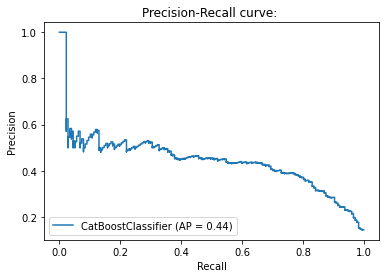

In [121]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(model, X_test, y_test)
disp.ax_.set_title('Precision-Recall curve: ')

#### CATBoost Feature Importances

In [25]:
## Assess Metrics
from catboost import CatBoostClassifier
model = CatBoostClassifier(border_count = 5, iterations = 1000, l2_leaf_reg = 10, 
                          depth = 7, learning_rate = 0.3, class_weights = [1, 100])
model.fit(X_train,y_train)
prediction_test = model.predict(X_test)
prediction_val = model.predict(X_val)

0:	learn: 0.4335060	total: 34.4ms	remaining: 34.4s
1:	learn: 0.3430652	total: 63.7ms	remaining: 31.8s
2:	learn: 0.2655823	total: 87.6ms	remaining: 29.1s
3:	learn: 0.2263241	total: 145ms	remaining: 36s
4:	learn: 0.2061110	total: 185ms	remaining: 36.9s
5:	learn: 0.1948984	total: 245ms	remaining: 40.5s
6:	learn: 0.1886172	total: 276ms	remaining: 39.1s
7:	learn: 0.1774689	total: 360ms	remaining: 44.6s
8:	learn: 0.1744844	total: 393ms	remaining: 43.3s
9:	learn: 0.1664446	total: 414ms	remaining: 41s
10:	learn: 0.1596847	total: 450ms	remaining: 40.5s
11:	learn: 0.1561008	total: 510ms	remaining: 42s
12:	learn: 0.1503000	total: 548ms	remaining: 41.6s
13:	learn: 0.1473679	total: 576ms	remaining: 40.6s
14:	learn: 0.1458112	total: 604ms	remaining: 39.7s
15:	learn: 0.1442685	total: 628ms	remaining: 38.6s
16:	learn: 0.1436759	total: 660ms	remaining: 38.2s
17:	learn: 0.1425612	total: 715ms	remaining: 39s
18:	learn: 0.1405727	total: 738ms	remaining: 38.1s
19:	learn: 0.1396273	total: 775ms	remaining: 3

164:	learn: 0.0818889	total: 5.18s	remaining: 26.2s
165:	learn: 0.0818872	total: 5.22s	remaining: 26.2s
166:	learn: 0.0818857	total: 5.24s	remaining: 26.1s
167:	learn: 0.0818842	total: 5.25s	remaining: 26s
168:	learn: 0.0818829	total: 5.27s	remaining: 25.9s
169:	learn: 0.0818816	total: 5.3s	remaining: 25.9s
170:	learn: 0.0818803	total: 5.32s	remaining: 25.8s
171:	learn: 0.0818791	total: 5.33s	remaining: 25.7s
172:	learn: 0.0818780	total: 5.35s	remaining: 25.6s
173:	learn: 0.0818770	total: 5.38s	remaining: 25.5s
174:	learn: 0.0818759	total: 5.4s	remaining: 25.4s
175:	learn: 0.0818750	total: 5.42s	remaining: 25.4s
176:	learn: 0.0818741	total: 5.44s	remaining: 25.3s
177:	learn: 0.0818732	total: 5.46s	remaining: 25.2s
178:	learn: 0.0818723	total: 5.48s	remaining: 25.1s
179:	learn: 0.0818572	total: 5.5s	remaining: 25.1s
180:	learn: 0.0818564	total: 5.51s	remaining: 25s
181:	learn: 0.0816567	total: 5.53s	remaining: 24.9s
182:	learn: 0.0813667	total: 5.57s	remaining: 24.9s
183:	learn: 0.08122

323:	learn: 0.0696549	total: 8.75s	remaining: 18.3s
324:	learn: 0.0696301	total: 8.77s	remaining: 18.2s
325:	learn: 0.0696298	total: 8.79s	remaining: 18.2s
326:	learn: 0.0696295	total: 8.8s	remaining: 18.1s
327:	learn: 0.0696286	total: 8.82s	remaining: 18.1s
328:	learn: 0.0694392	total: 8.84s	remaining: 18s
329:	learn: 0.0693467	total: 8.87s	remaining: 18s
330:	learn: 0.0691678	total: 8.91s	remaining: 18s
331:	learn: 0.0690610	total: 8.95s	remaining: 18s
332:	learn: 0.0689946	total: 8.99s	remaining: 18s
333:	learn: 0.0689190	total: 9.01s	remaining: 18s
334:	learn: 0.0688484	total: 9.03s	remaining: 17.9s
335:	learn: 0.0688450	total: 9.05s	remaining: 17.9s
336:	learn: 0.0688445	total: 9.07s	remaining: 17.8s
337:	learn: 0.0687621	total: 9.09s	remaining: 17.8s
338:	learn: 0.0687594	total: 9.11s	remaining: 17.8s
339:	learn: 0.0687570	total: 9.13s	remaining: 17.7s
340:	learn: 0.0687560	total: 9.15s	remaining: 17.7s
341:	learn: 0.0687557	total: 9.16s	remaining: 17.6s
342:	learn: 0.0687537	tot

488:	learn: 0.0631406	total: 12.7s	remaining: 13.3s
489:	learn: 0.0630725	total: 12.8s	remaining: 13.3s
490:	learn: 0.0630704	total: 12.8s	remaining: 13.2s
491:	learn: 0.0630685	total: 12.8s	remaining: 13.2s
492:	learn: 0.0630666	total: 12.8s	remaining: 13.2s
493:	learn: 0.0630649	total: 12.8s	remaining: 13.1s
494:	learn: 0.0630633	total: 12.9s	remaining: 13.1s
495:	learn: 0.0630618	total: 12.9s	remaining: 13.1s
496:	learn: 0.0630603	total: 12.9s	remaining: 13s
497:	learn: 0.0630589	total: 12.9s	remaining: 13s
498:	learn: 0.0630008	total: 12.9s	remaining: 13s
499:	learn: 0.0629992	total: 13s	remaining: 13s
500:	learn: 0.0629978	total: 13s	remaining: 13s
501:	learn: 0.0629965	total: 13s	remaining: 12.9s
502:	learn: 0.0629953	total: 13.1s	remaining: 12.9s
503:	learn: 0.0629941	total: 13.1s	remaining: 12.9s
504:	learn: 0.0629931	total: 13.1s	remaining: 12.8s
505:	learn: 0.0629920	total: 13.1s	remaining: 12.8s
506:	learn: 0.0629910	total: 13.2s	remaining: 12.8s
507:	learn: 0.0629901	total:

653:	learn: 0.0620766	total: 16.5s	remaining: 8.74s
654:	learn: 0.0620764	total: 16.5s	remaining: 8.71s
655:	learn: 0.0620762	total: 16.6s	remaining: 8.68s
656:	learn: 0.0620754	total: 16.6s	remaining: 8.66s
657:	learn: 0.0620753	total: 16.6s	remaining: 8.63s
658:	learn: 0.0620751	total: 16.6s	remaining: 8.61s
659:	learn: 0.0620746	total: 16.7s	remaining: 8.58s
660:	learn: 0.0620744	total: 16.7s	remaining: 8.55s
661:	learn: 0.0620743	total: 16.7s	remaining: 8.52s
662:	learn: 0.0620741	total: 16.7s	remaining: 8.5s
663:	learn: 0.0620738	total: 16.7s	remaining: 8.47s
664:	learn: 0.0620737	total: 16.8s	remaining: 8.44s
665:	learn: 0.0620736	total: 16.8s	remaining: 8.41s
666:	learn: 0.0620734	total: 16.8s	remaining: 8.38s
667:	learn: 0.0620732	total: 16.8s	remaining: 8.36s
668:	learn: 0.0620730	total: 16.8s	remaining: 8.33s
669:	learn: 0.0620728	total: 16.9s	remaining: 8.3s
670:	learn: 0.0620727	total: 16.9s	remaining: 8.27s
671:	learn: 0.0620725	total: 16.9s	remaining: 8.25s
672:	learn: 0.

819:	learn: 0.0612596	total: 20.9s	remaining: 4.59s
820:	learn: 0.0612593	total: 21s	remaining: 4.57s
821:	learn: 0.0612590	total: 21s	remaining: 4.54s
822:	learn: 0.0612587	total: 21s	remaining: 4.52s
823:	learn: 0.0612584	total: 21s	remaining: 4.49s
824:	learn: 0.0612581	total: 21s	remaining: 4.46s
825:	learn: 0.0612578	total: 21.1s	remaining: 4.44s
826:	learn: 0.0612575	total: 21.1s	remaining: 4.41s
827:	learn: 0.0612573	total: 21.1s	remaining: 4.39s
828:	learn: 0.0612570	total: 21.2s	remaining: 4.37s
829:	learn: 0.0612568	total: 21.2s	remaining: 4.34s
830:	learn: 0.0612565	total: 21.2s	remaining: 4.31s
831:	learn: 0.0612563	total: 21.2s	remaining: 4.29s
832:	learn: 0.0612561	total: 21.2s	remaining: 4.26s
833:	learn: 0.0612558	total: 21.3s	remaining: 4.24s
834:	learn: 0.0612556	total: 21.3s	remaining: 4.21s
835:	learn: 0.0612554	total: 21.4s	remaining: 4.19s
836:	learn: 0.0612552	total: 21.4s	remaining: 4.16s
837:	learn: 0.0612550	total: 21.4s	remaining: 4.13s
838:	learn: 0.0612547	

978:	learn: 0.0607575	total: 24.8s	remaining: 531ms
979:	learn: 0.0607573	total: 24.8s	remaining: 506ms
980:	learn: 0.0607572	total: 24.8s	remaining: 481ms
981:	learn: 0.0607572	total: 24.8s	remaining: 455ms
982:	learn: 0.0607572	total: 24.9s	remaining: 430ms
983:	learn: 0.0607571	total: 24.9s	remaining: 405ms
984:	learn: 0.0607571	total: 24.9s	remaining: 379ms
985:	learn: 0.0607570	total: 24.9s	remaining: 354ms
986:	learn: 0.0607569	total: 25s	remaining: 329ms
987:	learn: 0.0607568	total: 25s	remaining: 303ms
988:	learn: 0.0607568	total: 25s	remaining: 278ms
989:	learn: 0.0607567	total: 25s	remaining: 253ms
990:	learn: 0.0607567	total: 25.1s	remaining: 228ms
991:	learn: 0.0607566	total: 25.1s	remaining: 203ms
992:	learn: 0.0607565	total: 25.2s	remaining: 178ms
993:	learn: 0.0607564	total: 25.2s	remaining: 152ms
994:	learn: 0.0607564	total: 25.2s	remaining: 127ms
995:	learn: 0.0607564	total: 25.3s	remaining: 101ms
996:	learn: 0.0607564	total: 25.3s	remaining: 76.1ms
997:	learn: 0.06075

In [ ]:
# PredictionValuesChange shows how much on average the prediction changes if the feature value changes. 
# The bigger the value the bigger on average is the change to the prediction value if this 
# feature is changed.

In [26]:
pvc = list(model.get_feature_importance(type= "PredictionValuesChange"))

In [27]:
for i in range(0,44):
    print("{:.2f} \t {}".format(pvc[i] , data.columns[i]))

0.84 	 job_admin
1.37 	 job_blue-collar
0.29 	 job_entrepreneur
0.28 	 job_housemaid
1.32 	 job_management
0.31 	 job_retired
0.31 	 job_self-employed
0.61 	 job_services
0.19 	 job_student
1.01 	 job_technician
0.33 	 job_unemployed
0.05 	 job_unknown
0.76 	 marital_divorced
2.15 	 marital_married
1.24 	 marital_single
1.05 	 education_primary
1.12 	 education_secondary
1.69 	 education_tertiary
0.46 	 education_unknown
0.11 	 default_no
0.10 	 default_yes
2.39 	 housing_no
1.18 	 housing_yes
1.05 	 loan_no
0.82 	 loan_yes
2.37 	 contact_cellular
0.39 	 contact_telephone
4.09 	 contact_unknown
3.23 	 month_apr
2.16 	 month_aug
0.01 	 month_dec
2.73 	 month_feb
0.59 	 month_jan
2.48 	 month_jul
1.41 	 month_jun
2.02 	 month_mar
3.48 	 month_may
2.08 	 month_nov
1.49 	 month_oct
5.57 	 age
0.94 	 balance
9.40 	 day
28.43 	 duration
6.09 	 campaign


In [28]:
data_vals = data.columns[0:44]
PredVals = pd.DataFrame()
PredVals["x"] = data_vals
PredVals["y"] = pvc
PredVals.sort_values("y", inplace = True, ascending = False)

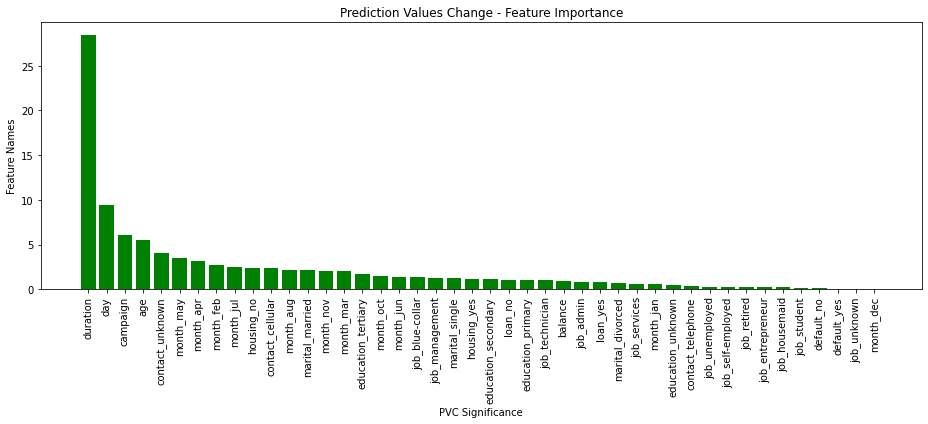

In [30]:
plt.figure(figsize = (13, 6))
plt.bar(PredVals.x, PredVals.y, color = 'green')
plt.xticks(rotation=90)
plt.title("Prediction Values Change - Feature Importance")
plt.xlabel("PVC Significance")
plt.ylabel("Feature Names")
plt.tight_layout()
plt.show()

In [ ]:
# LossFunctionChange involves taking the difference between the metric (Loss function) obtained using the model in 
# normal scenario (when we include the feature) and model without this feature 
# (model is built approximately using the original model with this feature removed from all the trees in the ensemble) 
# Higher the difference, the more important the feature is.

In [35]:
from catboost import Pool
train_x = pd.DataFrame(X_train, columns = data_vals)
train_y = pd.DataFrame(y_train, columns = ["y"])
train_data = Pool(data = train_x,
                  label = train_y)

In [36]:
lfc = list(model.get_feature_importance(train_data, type= "LossFunctionChange"))

In [37]:
data_vals = data.columns[0:44]
LossFn = pd.DataFrame()
LossFn["x"] = data_vals
LossFn["y"] = lfc
LossFn.sort_values("y", inplace = True, ascending = False)

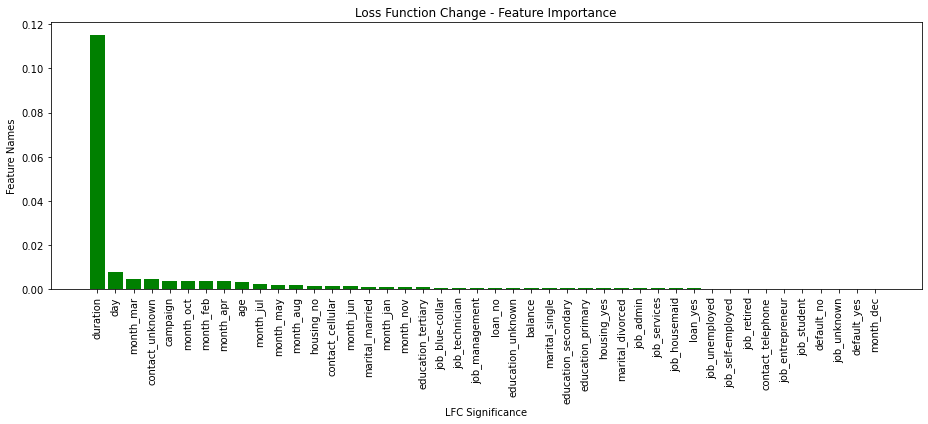

In [39]:
plt.figure(figsize = (13, 6))
plt.bar(LossFn.x, LossFn.y, color = 'green')
plt.xticks(rotation=90)
plt.title("Loss Function Change - Feature Importance")
plt.xlabel("LFC Significance")
plt.ylabel("Feature Names")
plt.tight_layout()
plt.show()

In [465]:
# SHAP Values (SHapley Additive exPlanations) break down a prediction to show the impact of each feature.
# sum(SHAP values for all features) = single_prediction - prediction_for_baseline_values

In [40]:
X_test[row_to_show]

array([-1.12166667e-01, -2.33666667e-01, -3.57083333e-02, -2.50833333e-02,
       -2.04750000e-01, -3.68750000e-02, -3.60833333e-02,  9.03083333e-01,
       -1.30833333e-02, -1.71541667e-01, -2.77916667e-02, -6.33333333e-03,
       -1.19125000e-01,  3.92625000e-01, -2.73500000e-01, -1.54500000e-01,
        4.74875000e-01, -2.81750000e-01, -3.86250000e-02,  1.97500000e-02,
       -1.97500000e-02, -4.01375000e-01,  4.01375000e-01,  1.71708333e-01,
       -1.71708333e-01,  3.79416667e-01, -5.83333333e-02, -3.21083333e-01,
       -6.70416667e-02, -1.32333333e-01, -4.16666667e-04, -5.79583333e-02,
       -2.80416667e-02, -1.58625000e-01,  8.79916667e-01, -6.58333333e-03,
       -3.38166667e-01, -8.88750000e-02, -1.87500000e-03, -8.00462963e-03,
       -1.00648148e-02, -5.62986111e-01,  6.96342593e-02, -3.34370370e-01])

In [41]:
# Checking shap value for a random prediction
row_to_show = 9
data_for_prediction = X_test[row_to_show]  
data_for_prediction_array = data_for_prediction.reshape(1, -1)

In [42]:
model.predict_proba(data_for_prediction_array)

array([[0.03396647, 0.96603353]])

In [45]:
import shap
# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)

In [58]:
# Calculate Shap values
test_data = pd.DataFrame(X_test, columns = data_vals)
shap_values = explainer.shap_values(test_data)

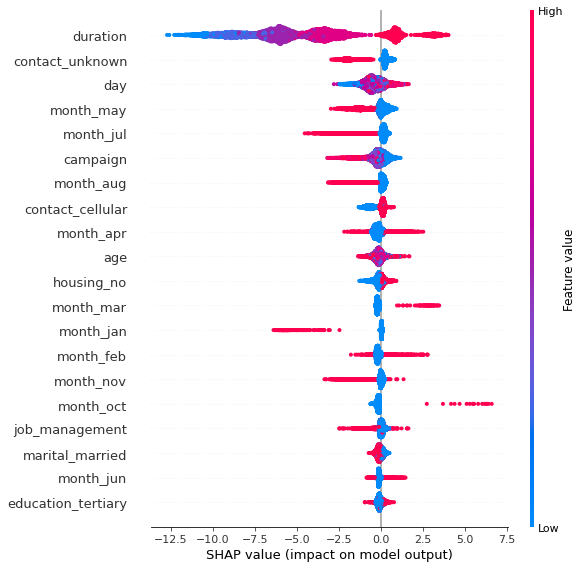

In [59]:
shap.summary_plot(shap_values, test_data)

In [66]:
from sklearn.inspection import permutation_importance
results = permutation_importance(model, X_train, y_train, scoring = f2score)
importance = results.importances_mean

In [ ]:
# Permutation Feature Importance
# Importance is measured by calculating the increase in model's prediction error after permuting the feature
# A feature is "important" if shuffling its values increases the model error
#(because in this case the model relied on the feature for the prediction)
# A feature is "unimportant" if shuffling its values leaves the model error unchanged
#(because in this case the model ignored the feature for the prediction)

In [69]:
data_vals = data.columns[0:44]
PermImp = pd.DataFrame()
PermImp["x"] = data_vals
PermImp["y"] = list(importance)
PermImp.sort_values("y", inplace = True, ascending = False)

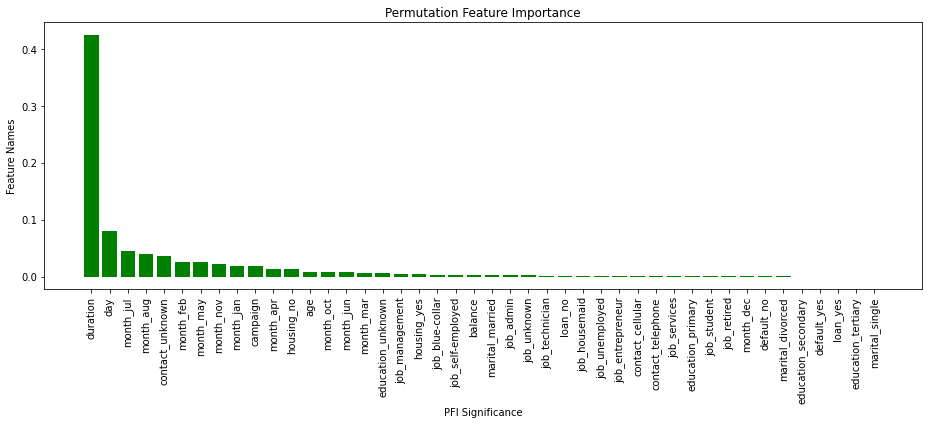

In [70]:
plt.figure(figsize = (13, 6))
plt.bar(PermImp.x, PermImp.y, color = 'green')
plt.xticks(rotation=90)
plt.title("Permutation Feature Importance")
plt.xlabel("PFI Significance")
plt.ylabel("Feature Names")
plt.tight_layout()
plt.show()

In [ ]:
# Specific Numerical Feature Analysis

#### Significant Features

In [16]:
df =  pd.read_csv("D:\Apziva\\term-deposit-marketing-2020.csv")

In [17]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [18]:
numerical_features_df = df.select_dtypes(include=[np.number])
categorical_features_df = df.select_dtypes(include=[np.object])
categorical_features_df = categorical_features_df.drop(columns = ["y"])
# numerical_features_df = numerical_features_df.drop(columns = ["duration"])
target = df["y"]

In [19]:
features_ohe = pd.get_dummies(categorical_features_df)

In [20]:
data = pd.concat([features_ohe, numerical_features_df, target], axis=1)
data["y"].replace({"yes": 1 , "no": 0}, inplace=True)

In [21]:
data

,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,month_mar,month_may,month_nov,month_oct,age,balance,day,duration,campaign,y
0,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,58,2143,5,261,1,0
1,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,44,29,5,151,1,0
2,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,33,2,5,76,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,47,1506,5,92,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,33,1,5,198,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,53,395,3,107,1,0
39996,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,30,3340,3,238,3,1
39997,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,54,200,3,170,1,1
39998,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,34,1047,3,342,1,0


In [22]:
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(data.drop('y',axis=1), data.y , test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=0)

In [23]:
prep_pipe = Pipeline([
    # Transformer
    ('yjt', YeoJohnsonTransformer(variables = continuous)),
    
    # Discretiser
    ('ew_disc', EqualWidthDiscretiser(bins=10, variables = continuous)),
    
    # Scaling
    ("standardscaler" , StandardScaler(with_mean=True, with_std=False)),
    ("robustscaler" , RobustScaler(with_centering=False, with_scaling=True, quantile_range=(0, 100))) 
    ])

In [24]:
prep_pipe.fit(X_train, y_train)
X_train = prep_pipe.transform(X_train)
X_val = prep_pipe.transform(X_val)
X_test = prep_pipe.transform(X_test)

In [237]:
# Using Logistic regression with l2 - ridge penalty
logreg_feat = LogisticRegression(C = 0.2, class_weight = {0: 1, 1: 10}, dual = False, fit_intercept = True,
                                              penalty = 'l2', solver = 'sag', warm_start = True,
                                              random_state = 42, max_iter = 10000)
logreg_feat.fit(X_train,y_train)

# Identifying which columns have been given preference while making the predictions by checking coefficient values
print('Coefficient of each feature:', logreg_feat.coef_)

Coefficient of each feature: [[ 1.93678535e-01 -1.03144872e-01 -1.60390836e-01 -4.50679847e-01
  -3.39465174e-02  4.69970172e-01 -1.24102348e-01 -6.52553815e-02
   4.60152497e-01  1.14268071e-01 -9.20583828e-02 -2.08491090e-01
   9.48508587e-02 -2.09202902e-01  1.14352043e-01 -7.48670303e-02
   1.30368436e-02  2.85127324e-01 -2.23297137e-01 -1.25410908e-01
   1.25410908e-01  3.70921811e-01 -3.70921811e-01  2.08406034e-01
  -2.08406034e-01  5.95665688e-01  5.53889619e-01 -1.14955531e+00
   2.69967837e-01 -1.73949111e+00  6.05928044e-01  1.57626296e-01
  -2.99886466e+00 -1.55296393e+00  4.03719782e-01  2.51912395e+00
  -4.97457458e-01 -1.25839933e+00  4.09081058e+00 -3.88218768e-01
   1.06192675e+00  6.94940639e-01  1.48085002e+01 -2.10900370e-01]]


In [238]:
coef = logreg_feat.coef_

In [239]:
for i in coef:
    for j in range(0,44):
        print("{:.2f} \t {}".format(i[j] , data.columns[j]))

0.19 	 job_admin
-0.10 	 job_blue-collar
-0.16 	 job_entrepreneur
-0.45 	 job_housemaid
-0.03 	 job_management
0.47 	 job_retired
-0.12 	 job_self-employed
-0.07 	 job_services
0.46 	 job_student
0.11 	 job_technician
-0.09 	 job_unemployed
-0.21 	 job_unknown
0.09 	 marital_divorced
-0.21 	 marital_married
0.11 	 marital_single
-0.07 	 education_primary
0.01 	 education_secondary
0.29 	 education_tertiary
-0.22 	 education_unknown
-0.13 	 default_no
0.13 	 default_yes
0.37 	 housing_no
-0.37 	 housing_yes
0.21 	 loan_no
-0.21 	 loan_yes
0.60 	 contact_cellular
0.55 	 contact_telephone
-1.15 	 contact_unknown
0.27 	 month_apr
-1.74 	 month_aug
0.61 	 month_dec
0.16 	 month_feb
-3.00 	 month_jan
-1.55 	 month_jul
0.40 	 month_jun
2.52 	 month_mar
-0.50 	 month_may
-1.26 	 month_nov
4.09 	 month_oct
-0.39 	 age
1.06 	 balance
0.69 	 day
14.81 	 duration
-0.21 	 campaign


Significance of Features:

Duration:
Duration since last contact seems to have the highest significane with respect to the subscription. Larger the duration more likely the customer is to make a subscription. (This seems like an unusual inference)

Balance:
Balance has a positive relation with subscription. It makes sense to target consumers that have a high average yearly balance.

Age:
In general a younger demographic is more likey to make the subscription.

Day:
People are more likey to subscribe to the deposit when contacted on days later in the month.

Month: (Unusual)
Contacting people in the following months have had the most success: October, March
Contacting people in the following months have had the least success: January, August, July

Education:
People with higher levels of education are more likely to make the financial investment

Job: This is relatively not too sigificant a feature.
People with the following jobs are more likely to make subscriptions: Retired, Students, Technician, Admin
People with the following jobs are unlikey to make subscriptions: Housemaids, Entrepreneurs, Self-Employed

In [ ]:
# a = data.groupby("job")
# for name, group in a:
#     print(name)
#     print(group["y"].value_counts())

#### PCA

In [243]:
## PCA
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [254]:
from sklearn.pipeline import Pipeline
from feature_engine.categorical_encoders import OneHotCategoricalEncoder
prep_pipe = Pipeline([
    # Encoding
    ('Standard Scaler', StandardScaler())
    ])  

In [255]:
prep_pipe.fit(data)
df = prep_pipe.transform(data)

In [256]:
pca = PCA()
principalComponents = pca.fit_transform(df)

([<matplotlib.axis.XTick at 0x2298080a788>,
 <a list of 45 Text major ticklabel objects>)

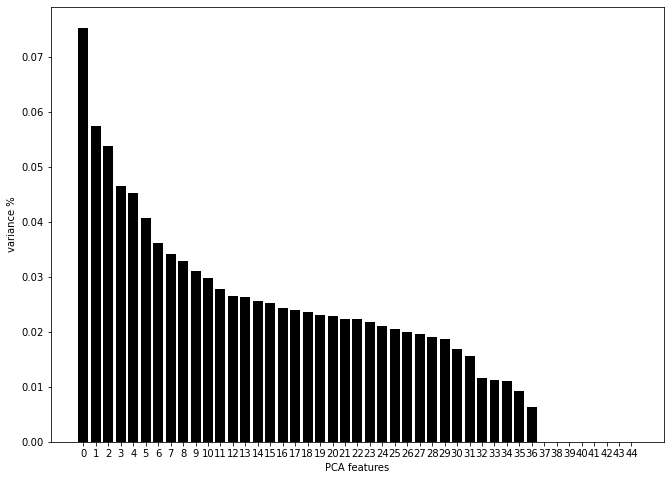

In [267]:
features = range(pca.n_components_)
from matplotlib.pyplot import figure
figure(num=None, figsize=(11, 8))
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

In [265]:
print(pd.DataFrame(pca.components_,columns=data.columns))

    job_admin  job_blue-collar  job_entrepreneur  job_housemaid  \
0   -0.058258    -2.051792e-01      1.306769e-02   3.272134e-02   
1   -0.092101     1.309471e-01      2.863643e-02   1.382964e-01   
2    0.099585     6.916169e-02      1.589856e-02  -1.236666e-03   
3   -0.051442    -1.173552e-01      5.387971e-02  -1.492754e-02   
4    0.148074    -1.214606e-01     -8.241636e-02   2.490475e-02   
5   -0.048852     1.859780e-01     -3.011616e-02   2.869337e-02   
6   -0.008398     1.634803e-01      1.341925e-02   5.199125e-02   
7   -0.118207     3.413228e-01     -7.797484e-02   1.190692e-01   
8    0.123360    -1.628742e-01      4.203944e-02   9.835309e-03   
9   -0.116530     8.760390e-02     -3.381515e-02  -7.255350e-02   
10   0.127944    -9.711915e-02      1.439661e-01  -6.104185e-02   
11  -0.066313     1.093320e-01      9.895489e-02   1.602238e-02   
12  -0.202634     7.930481e-02     -2.337113e-02  -1.113738e-01   
13  -0.038373    -4.430200e-02      8.764091e-02  -1.953223e-0

In [272]:
n_pcs= pca.components_.shape[0]
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = data.columns
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}
df = pd.DataFrame(sorted(dic.items()))

In [273]:
df

,0,1
0,PC1,contact_unknown
1,PC10,marital_divorced
2,PC11,marital_divorced
3,PC12,month_nov
4,PC13,job_technician
5,PC14,education_unknown
6,PC15,month_jan
7,PC16,job_admin
8,PC17,job_services
9,PC18,month_apr


#### TSNE

In [281]:
data =  pd.read_csv("D:\Apziva\\term-deposit-marketing-2020.csv")
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [299]:
X = data.iloc[:,:-1]
y = data["y"]

In [315]:
from sklearn.manifold import TSNE
X_embedded = TSNE(perplexity = 30, n_iter = 2500).fit_transform(X)

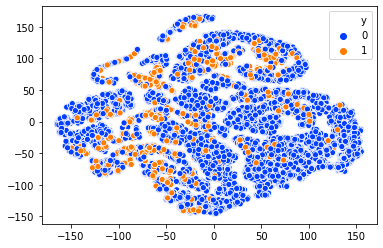

In [316]:
palette = sns.color_palette("bright", 2)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue =y, legend='full', palette=palette)

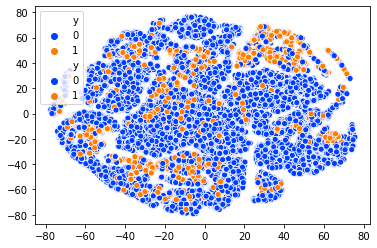

In [307]:
palette = sns.color_palette("bright", 2)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue =y, legend='full', palette=palette)

#### k-means Clustering

In [283]:
data =  pd.read_csv("D:\Apziva\\term-deposit-marketing-2020.csv")
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [284]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'y'],
      dtype='object')

In [ ]:
# clust = df.drop('column_name', axis=1, inplace=True)

In [285]:
from sklearn.pipeline import Pipeline
from feature_engine.categorical_encoders import OneHotCategoricalEncoder
prep_pipe = Pipeline([
    # Encoding
    ('OneHotEncoder', OneHotCategoricalEncoder(variables = ['job', 'marital', 'education', 'default',
                                                           'housing', 'loan', 'contact', 'month','y'],
                                               top_categories = None,
                                               drop_last = False))
    ])

In [286]:
prep_pipe.fit(data)
df = prep_pipe.transform(data)

In [79]:
X = df.iloc[:,:].values

In [82]:
from sklearn.cluster import KMeans
wcss = []
for k in range(1,10):
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

Text(0, 0.5, 'WCSS')

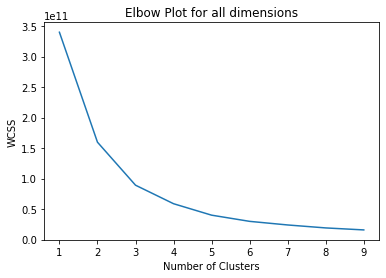

In [83]:
plt.plot(range(1, 10), wcss)
plt.title("Elbow Plot for all dimensions")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")

In [84]:
# Chooing k = 3 since after this point the drop in ecss is relatively less
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
ykmeans = kmeans.fit_predict(X)

In [86]:
print(ykmeans)

[0 0 0 ... 0 0 0]
